In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

from toy_samples import gaussian_samples
from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, logPr

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("test_samples/samples_1.pickle")

In [2]:
def logt_sample(n):
    p = np.random.rand()
    return 1/n * np.log(p)
logt_sample = np.vectorize(logt_sample)

def X_sample(nk):
    logt_samples = logt_sample(nk)
    logX = np.sum(logt_samples)
    X = np.exp(logX)
    return X

def generate_Xs(nk, iterations=None):
    logt_samples = logt_sample(nk)
    logXs = np.cumsum(logt_samples)
    Xs = np.exp(logXs)
    if iterations is not None:
        return np.take(Xs, iterations)
    return Xs

In [45]:
def logL_X(X, theta):
    d, sigma = theta
    return - X**(2/d)/(2*sigma**2)

def X_logL(logL, theta):
    d, sigma = theta
    return np.exp(d/2 * np.log(-2*sigma**2*logL))

def minimize_theta(logL, mean, cov_inv, x0):
    def func(theta):
        X = X_logL(logL, theta)
        return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

In [101]:
nk = 500 * np.ones(1000)
iterations = np.arange(5, 1000, 5)
repeats = 1000
X_samples = np.zeros((repeats, len(iterations)))
for i in range(repeats):
    X_samples[i] = generate_Xs(nk, iterations)
mean_X = np.mean(X_samples, axis=0)
cov_X = np.cov(X_samples.T)
covinv_X = np.linalg.inv(cov_X)

In [40]:
def generate_Xstats(nk, iterations=None):
    if iterations is None:
        N_iterations = len(nk)
    else:
        N_iterations = len(iterations)
    repeats = 5000
    X_samples = np.zeros((repeats, N_iterations))
    for i in range(repeats):
        X_samples[i] = generate_Xs(nk, iterations)
    mean_X = np.mean(X_samples, axis=0)
    cov_X = np.cov(X_samples.T)
    covinv_X = np.linalg.inv(cov_X)
    return mean_X, covinv_X

In [5]:
X_sample = generate_Xs(nk, iterations)
logL = logL_X(X_sample, [10, 0.1])
minimize_theta(logL, mean_X, covinv_X, [10,0.1]).x

NameError: name 'nk' is not defined

In [54]:
points = points_at_iteration(samples_g_1, 500)
nk = np.array(points.nlive)
mean_X, covinv_X = generate_Xstats(nk)

In [55]:
logL = points.logL

In [56]:
from covariance import logX_model, logPr
def optimise_pr_cg(logL, mean, cov_inv, x0):
    def func(theta):
        logX = logX_model(logL, *theta)
        return - logPr(logX, mean, cov_inv) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0, method='Nelder-Mead')
    return solution

In [45]:
from covariance import logPr_params

logPr_test = logPr_params(logL, mean, covinv, [-2, 8.9, 0.1])
print(f"{logPr_test:.2e}")

-3.53e+07


In [57]:
from lm_partial import analytic_lm_params
analytic_lm_params(logL, mean_X, 10)

[-1.6307473394785745, 8.97265352461834, 0.10176917006706997]

In [58]:
params_cg = optimise_pr_cg(logL, mean_X, covinv_X, [-2, 10, 0.1]).x

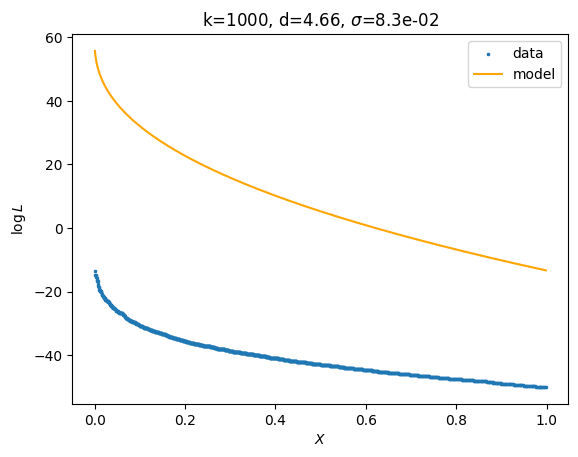

In [59]:
from plotting import plot_fit_raw
plot_fit_raw(mean_X, logL, params_cg)

## Contour plots

In [245]:
logX_means = []
for i in range(5):
    logX1s, logX2s = generate_logXs(1000)
    logX = np.array([logX1s, logX2s]).T
    mean = logX.mean(axis=0)
    logX_means.append(mean)